In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set()

from bond_pricer import FixedCouponBond, ONE_PCT, ONE_BP

### Bond term sheet
* Maturity: 3 years
* Frequency : semiannual
* 10% coupon

In [2]:
coupon = 10 * ONE_PCT
principal = 100 * ONE_PCT
coupon_frequency = 2
maturity = 3

term_sheet = defaultdict(
    None,
    {
        'coupon': coupon,
        'principal': principal,
        'coupon_frequency': coupon_frequency,
        'maturity': maturity,
    }
)

bond = FixedCouponBond(term_sheet)

### Fix bond price at 95

Recall the yield/price formula:

$$
P = \sum_{t=1}^{T} \frac{\delta\times Coupon}{(1+\delta\times YTM)^{\frac{t}{\delta}}} + \frac{Principal}{(1+\delta\times YTM)^{\frac{T}{\delta}}}.
$$

where $\delta$ is the day count fraction, $T$ the maturity.

In [3]:
P = 95 * ONE_PCT
YTM = bond.price_to_yield(P)

print('Price: {:.2%}'.format(P))
print('YTM: {:.2%}'.format(YTM))

Price: 95.00%
YTM: 12.03%


### DV01

The **Dollar Value of an 01 (basis point)** aka **DV01** represents the change in bond price for a 1 basis point change in yield to maturity. 

The derivative of $P$ with respect to $YTM$ is :

$$
\frac{\Delta P}{\Delta YTM} = \frac{1}{1+\delta\times Y} \bigg( \sum_{t=1}^{T}\frac{\delta\times Coupon\times t}{(1+\delta\times YTM)^{\frac{t}{\delta}}} + \frac{Principal\times T}{(1+\delta\times YTM)^{\frac{T}{\delta}}} \bigg).
$$

Due to the inverse relation between price and yield, a 1 bp increase in YTM pushes the price down. Therefore in practice, market participants define DV01 and the inverse of the this quantity:

$$
DV01 = - \frac{\Delta P}{\Delta YTM}
$$

With this convention, when a trader has long position (he bought and held the bond in inventory), its associated DV01 is positive.

In other words, DV01 represents the **yield risk** of a bond investor i.e its expected PnL under a given change in yield.

In practice, rather than using the formula, it can be approximated by finite difference, i.e by pricing the bond with two different yields, separated by 1 bp:

$$
DV01 \approx \frac{P(YTM-1bp) - P(YTM)}{1bp} 
$$

In [4]:
print('DV01: {:.4f}'.format(bond.dv01(P)))
approx_dv01 = (bond.yield_to_price(YTM - ONE_BP) - bond.yield_to_price(YTM)) / ONE_BP
print('DV01 (finite difference): {:.4f}'.format(approx_dv01))

DV01: 2.3788
DV01 (finite difference): 2.3792


### Duration

Notice how the terms $t$ appears in the above formula for $\frac{\Delta P}{\Delta YTM}$ : each term inside the sum is homogeneous to a duration. Up to a multiplicative factor, the DV01 is the sum of yield-discounted expected cashflows weighted by their durations.

This leads to a few alternative definitions of DV01 that higlights this resemblance to a duration. First we have the **Modified Duration**, which expresses the DV01 risk as a fraction of the bond price :

$$
\text{Modified Duration} = \frac{1}{P} \frac{\Delta P}{\Delta YTM} = -\frac{1}{P} DV01.
$$

Another definition is the **Macaulay Duration**, which is the \textit{relative} change in price $\frac{\Delta P}{P}$ with respect to a \textit{relative} change in yield $\frac{\Delta YTM}{1+\delta\times YTM}$:

$$
\text{Macaulay Duration} =
\frac{1}{P} \bigg( \sum_{t=1}^{T}\frac{\delta\times Coupon\times t}{(1+\delta\times YTM)^{\frac{t}{\delta}}} + \frac{Principal\times T}{(1+\delta\times YTM)^{\frac{T}{\delta}}} \bigg).
$$




In [5]:
print('Modified Duration: {:.4f}'.format(bond.modified_duration(P)))
print('Macaulay Duration: {:.4f}'.format(bond.macaulay_duration(P)))

Modified Duration: 2.5040
Macaulay Duration: 2.6547


### Macaulay duration as a time to equilibrium

The Macaulay duration has a nice interpretation that helps visualize duration. 

Imagine each payment, coupons and principal, as a marble placed on a board at a position corresponding to its payment date with a weight equal to its value. Then the Macaulay duration is the center of mass of the board, that is the point of equilibrium of the board. 

In more financial words, it is the average number of years before the investment breaks even, after discounting by the yield and taking into account the remaining time before principal payment. 

In [6]:
def plot_macaulay(bond):
    fig, ax = plt.subplots(figsize=(11, 5), nrows=1, ncols=1)

    macaulay_dur = bond.macaulay_duration(P)

    ax.bar(bond.coupon_dates, bond.coupon_cashflows, width=0.25, alpha=1.0, label='coupon')
    ax.bar(bond.maturity, bond.principal, width=0.25, alpha=0.6, label='principal')

    ax.axvline(macaulay_dur, 0.1, linestyle='dashed', alpha=0.8)
    ax.annotate('Macaulay duration\n--> the board is at equilibrium', 
                (macaulay_dur-0.7, 0.7)
               )

    ax.axhline(0)

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: 'year {:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(loc='upper left')

    ax.set_ylim(-0.1, 1)

    triangle = [
        [macaulay_dur, 0],
        [macaulay_dur-0.5, -0.1],
        [macaulay_dur+0.5, -0.1]
    ]

    t1 = plt.Polygon(triangle, color='b', alpha=0.5)
    plt.gca().add_patch(t1)

    plt.tight_layout()
    plt.show()

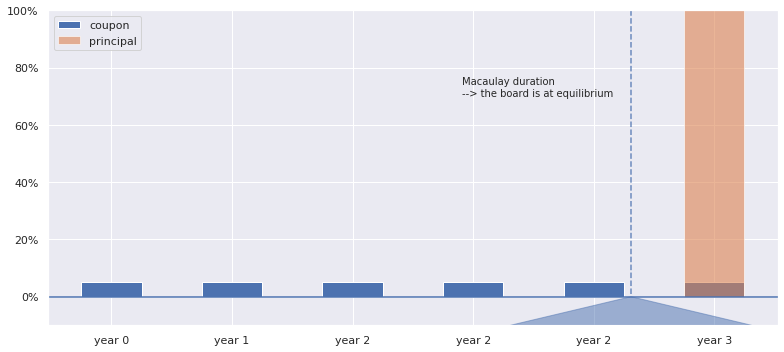

In [7]:
plot_macaulay(bond)

### Macaulay duration for a zero-coupon bond

Note that for a zero-coupon bond, the Macaulay duration is exactly the maturity: since no running interest is paid, after discounting the yield the investment can only break even when receiving the only due cashflow.

In [8]:
principal = 100 * ONE_PCT
coupon_frequency = 2
maturity = 3

term_sheet_zc = defaultdict(
    None,
    {
        'coupon': 0.0,
        'principal': principal,
        'coupon_frequency': coupon_frequency,
        'maturity': maturity,
    }
)

zc = FixedCouponBond(term_sheet_zc)

In [9]:
print('Macaulay Duration: {:.4f}'.format(zc.macaulay_duration(P)))

Macaulay Duration: 3.0000


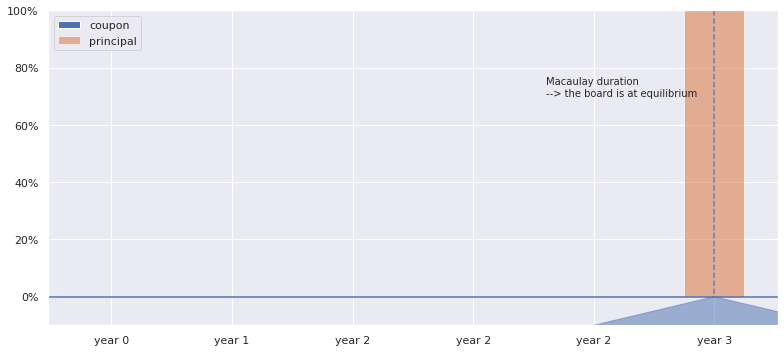

In [10]:
plot_macaulay(zc)

### Risk management using duration

The Macaulay interpretation gives an interesting insight to compare bond risks: all else being equal, the longer the maturity, the longer the Macaulay duration, and therefore the larger the risk. Another interpretation is that longer-dated bonds bear more cashflows, and changes in yield affect all cashflows, so longer-dated bonds are more prone to large swings in price.

A good rule of thumb to quickly assess the risk of a bond is that it loses as many price points per % of yield increase as there are years before maturity. This is most accurate when coupons are low and price is close to par, and the reason is that in this case the DV01 is close to the Macaulay duration, which itself is close to the maturity. 